# Tutorial: Using DRISE to Explain Object Detection Models

## Introduction
This tutorial demonstrates how to use the **DRISE (Detector Randomized Input Sampling for Explanation)** method to generate **saliency maps** for black-box object detectors.

Black box object detectors are able to both localize and classify different objects in a single image. To see saliency map generation for classifying an image, see `Tutorial: Using Occlusion-based Saliency to Explain Image Classification Models`.

DRISE is a perturbation-based **saliency map generation technique** that helps interpret model decisions by analyzing how input modifications affect output predictions. DRISE is specifically made for object detection models and should not be used for image classification.

### Prerequisites
Before starting, ensure the following:

- XAITK-Saliency is installed (see [`Installation`](../installation.rst)).
- **Software Requirements:**
  - Python 3.9+ installed.
  - pip (Python package manager) installed.
- **Basic Skills:** Familiarity with Python programming and using the terminal or command line.


To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/docs/examples/DRISE.ipynb)

Note for Colab users: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the README for more info).

## The Test Image
We will test this application on the following image from [MS-COCO](https://cocodataset.org/#home).
We know that this image contains the MS-COCO classes of "dog" and "cat".

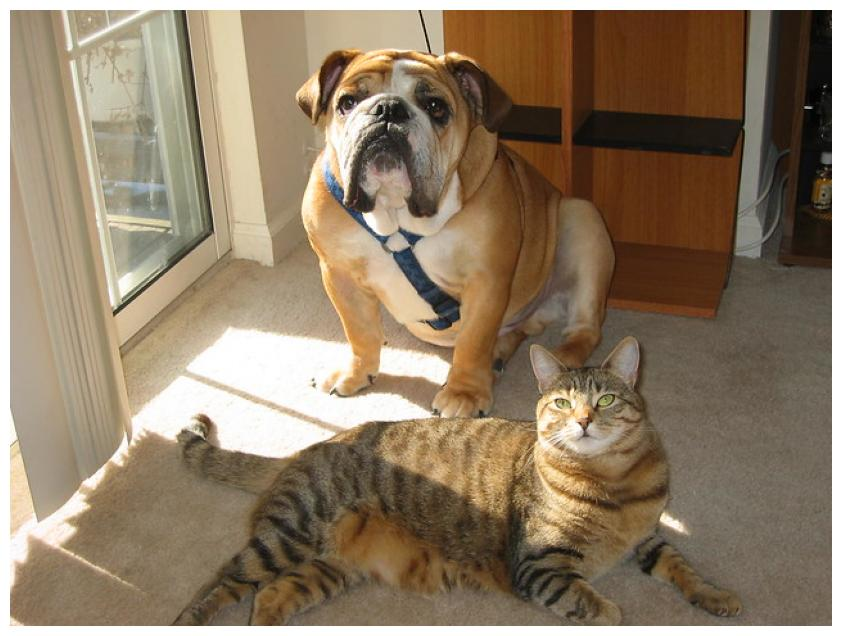

In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


# Test image to be explained
os.makedirs("data", exist_ok=True)
test_image_filename = "data/catdog.jpg"
urllib.request.urlretrieve("https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg", test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis("off")
ref_image = np.asarray(PIL.Image.open(test_image_filename))
_ = plt.imshow(ref_image)

## Load a Pre-trained Object Detection Model
In this example we will use a PyTorch-based, pretrained, [Faster-RCNN](https://arxiv.org/abs/1506.01497) object detector with a ResNet50 backbone.

The ResNetFRCNN class from SMQTK-Detection provides this as a `smqtk_detection.DetectImageObjects` implementation, as required for use with the `GenerateObjectDetectorBlackboxSaliency` interface. Any `smqtk_detection.DetectImageObjects` implementation can be used as the blackbox model for saliency generation. For an example of swapping models, see the How-Tos guides. 

The [DRISE](https://arxiv.org/abs/2006.03204) algorithm uses these class probabilities for computing similarity between reference and perturbed detections.

In [2]:
import warnings

import numpy as np
import torch
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN

warnings.filterwarnings("ignore", category=UserWarning)

CUDA_AVAILABLE = torch.cuda.is_available()

blackbox_detector = ResNetFRCNN(box_thresh=0.05, img_batch_size=1, use_cuda=CUDA_AVAILABLE)

model_mean = [0.485, 0.456, 0.406]
blackbox_fill = np.uint8(np.asarray(model_mean) * 255)

Before we can generate saliency maps, we first needs to define bounding boxes on objects to detect. We will use the first two predictions as our reference detections.

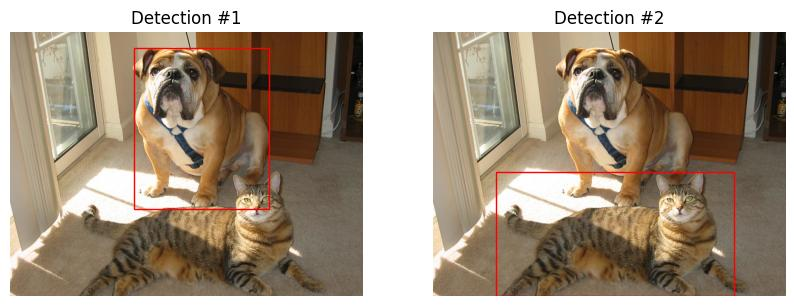

In [3]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Our reference detections are the first two predictions in the list
img_preds = list(list(blackbox_detector([ref_image]))[0])
ref_preds = img_preds[:2]

# For the saliency heatmap generation API we need reference image detections
# split into seperate bounding boxes and class score matrices
ref_bboxes = []
ref_scores = []
for det in ref_preds:
    bbox = det[0]
    ref_bboxes.append(
        [
            *bbox.min_vertex,
            *bbox.max_vertex,
        ],
    )

    score_dict = det[1]
    ref_scores.append(list(score_dict.values()))

ref_bboxes = np.array(ref_bboxes)
ref_scores = np.array(ref_scores)

_, axs = plt.subplots(1, 2, figsize=(10, 4))
for i, bbox in enumerate(ref_bboxes):
    axs[i].imshow(ref_image)
    rect = patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2] - bbox[0],
        bbox[3] - bbox[1],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    axs[i].add_patch(rect)
    axs[i].set_title(f"Detection #{i + 1}")
    axs[i].axis("off")

## Define the Saliency Algorithm
Here we will instantiate our `GenerateObjectDetectorBlackboxSaliency` implementation that combines image perturbation and detector-based saliency map generation into one call. We will use `DRISEStack` which is comprised of the `RISEGrid` and `DRISEScoring` image perturbation and saliency map generation methods, respectively.

For `DRISEStack`, there are three parameters that affect saliency generation: `n`, `s`, `p1`. `n` is the number of masks, `s` is the spatial resolution of the small masking grid, and `p1` is the probability of the grid cell to be set to 1.

In [4]:
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

sal_generator = DRISEStack(n=200, s=8, p1=0.5, seed=0, threads=4)

Now that we have reference detections, a saliency map generator, and a blackbox detector, we are ready to generate saliency maps. The section below will generate saliency maps.

In [5]:
import numpy as np
import PIL.Image

# Set our saliency generator to use the specified fill
sal_generator.fill = blackbox_fill

sal_maps = sal_generator.generate(
    ref_image,
    ref_bboxes,
    ref_scores,
    blackbox_detector,
)

## Visualization

Saliency maps will have a range of values from -1 to 1. Values close to 1 mean an increase of class confidence while values close to -1 mean a decrease in class confidence. Values around 0 have relatively low impact on class confidence. To relate the saliency map to the original image, the saliency map is overlaid onto the original image using a **colormap** (e.g., *jet*), highlighting influential regions. The meaning of the areas depends on the range of the color maps. In general:

- **Bright areas**: Increase class confidence.

- **Dark areas**: Decrease in class confidence.

Unlike other saliency map generation methods, the alignment of the bounding box is also a factor for DRISE saliency map generation. For more information, see the _Reference_ section for code documentation.

**Note**: DRISE saliency maps tend to have a small range of values. Be sure to check the range of the colormap to your understanding of the saliency map is correct.

The image below is the saliency map generated for the dog in the test image. You can see the dog's back had the highest class confidence because of the bright red section. The yellow sections around the dog's body also had an a positive effect on class confidence. The other parts of the image (curtains, floors, etc.) had a relatively low effect on the prediction. 

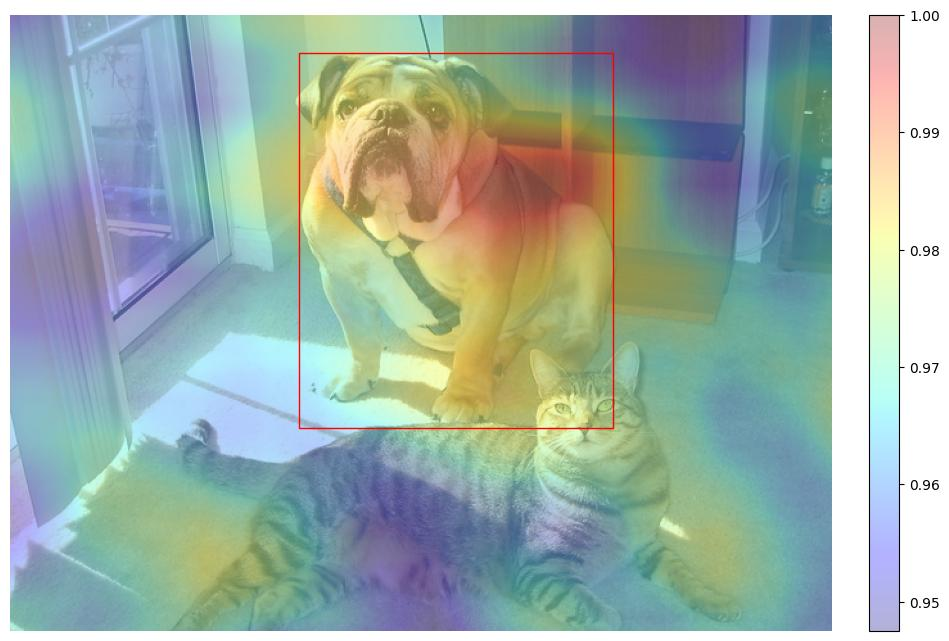

In [11]:
# Some magic numbers here to get colorbar to be roughly the same height
# as the plotted image.
colorbar_kwargs = {
    "fraction": 0.046 * (ref_image.shape[0] / ref_image.shape[1]),
    "pad": 0.04,
}
bbox = ref_bboxes[0]
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(ref_image, alpha=0.7)
plt.clim(-1, 1)
plt.imshow(sal_maps[0], cmap="jet", alpha=0.3)
ax = plt.gca()
rect = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)
_ = plt.colorbar(**colorbar_kwargs)

The image below is the saliency map generated for the cat in the test image. You can see the cat's legs have the highest class confidence for predicting the cat while the dog's face and the curtains have a relatively low effect on class confidence. 

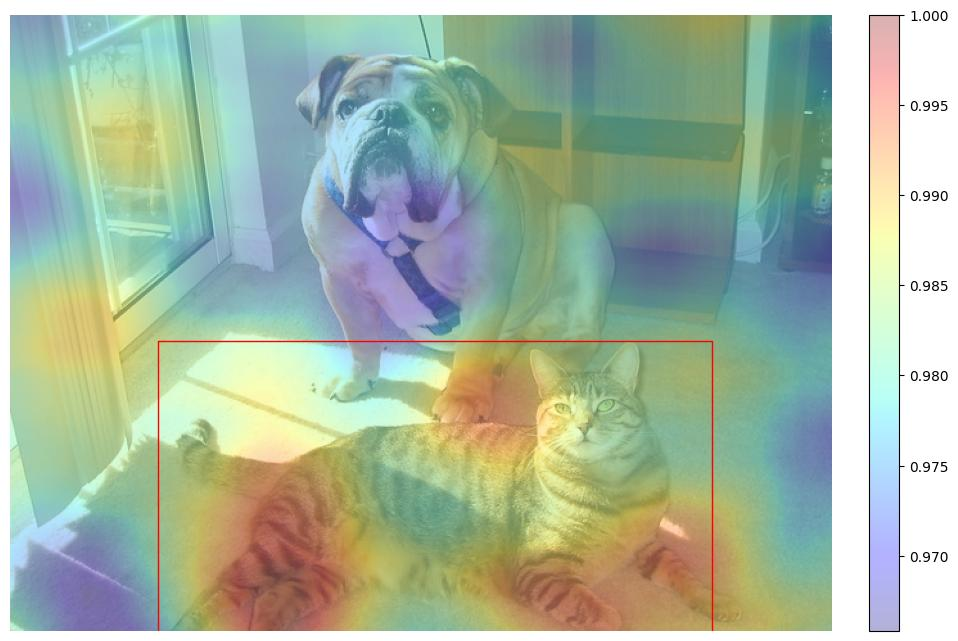

In [13]:
bbox = ref_bboxes[1]
plt.figure(figsize=(12, 8))
plt.axis("off")
plt.imshow(ref_image, alpha=0.7)
plt.clim(-1, 1)
plt.imshow(sal_maps[1], cmap="jet", alpha=0.3)
ax = plt.gca()
rect = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)
_ = plt.colorbar(**colorbar_kwargs)

## Next Steps

Now that you've completed this tutorial, see the [*How-To*](../review_process.rst) section for instructions on using other `Saliency Generation Examples`.

See the [*Reference*](../implementations.rst) section for code documentation.

## Further Reading

- [Original D-RISE Paper](https://arxiv.org/abs/2006.03204)
